In [1]:
import pandas as pd

In [2]:
path = "C:/Users/shrra/Downloads/2024-06-25T13-17_export.csv"
datafram =pd.read_csv(path)

In [3]:



def determine_new_race_5(row):
    if row['race___5'] and row['ethnicity'] == "Hispanic or Latino":
        return False
    else:
        return row['race___5']

# Apply the function to create the new column
datafram['new_race___5'] = datafram.apply(determine_new_race_5, axis=1)

# Remove rows where race___5 is false and race___8 is true
datafram = datafram[~((datafram['race___5'] == False) & (datafram['race___8'] == True))]

# race_columns = ['race___1', 'race___2', 'race___3', 'race___4', 'race___5','race___6', 'race___7','race___8','new_race___5']  
# race_counts = datafram[race_columns].sum()
# plt.figure(figsize=(10, 6))
# sns.barplot(x=race_counts.index, y=race_counts.values, palette='viridis')
# plt.xlabel('Race')
# plt.ylabel('Count')
# plt.title('Number of Counts Available for Each Race')
# plt.show()


# income_counts = datafram['household_income_usa'].value_counts()

# # Plotting the counts
# plt.figure(figsize=(10, 6))
# sns.barplot(x=income_counts.index, y=income_counts.values, palette='viridis')
# plt.xlabel('Household Income')
# plt.ylabel('Count')
# plt.title('Number of Counts Available for Each Household Income Bracket')
# plt.show()


In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Custom Dataset with Spectrogram Conversion and Padding
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, max_len=10000, n_fft=2048, hop_length=512, n_mels=128):
        self.file_paths = file_paths
        self.labels = labels
        self.max_len = max_len
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        spectrogram = self.wav_to_spectrogram(file_path)
        spectrogram = self.pad_spectrogram(spectrogram, self.max_len)
        label = self.labels.iloc[idx]
        return torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

    def wav_to_spectrogram(self, file_path):
        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
        S_db = librosa.power_to_db(S, ref=np.max)
        return S_db

    def pad_spectrogram(self, spec, max_len):
        if spec.shape[1] < max_len:
            pad_width = max_len - spec.shape[1]
            spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
        else:
            spec = spec[:, :max_len]
        return spec

# Load the DataFrame
df = datafram

selected_columns = ['record_id', 'demographics_session_id', 'new_race___5']
df = df[selected_columns]

df['subject_id'] = 'sub-' + df['record_id'] + '/ses-' + df['demographics_session_id']

# Split the DataFrame into train, validation, and test sets
train_ids, test_ids = train_test_split(df['subject_id'], test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

def get_file_paths(subject_ids, base_dir='C:/Users/shrra/Downloads/Bridge2AI/bridge2ai-voice-corpus-2-including-sensitive-recordings1/bids_with_sensitive_recordings/'):
    file_paths = []
    valid_ids = []
    for subject_id in subject_ids:
        session_dir = os.path.join(base_dir, subject_id, 'audio')
        found_file = False
        if os.path.exists(session_dir):
            for file_name in os.listdir(session_dir):
                if file_name.endswith('Rainbow-Passage_rec-Rainbow-Passage.wav'):  # Check for .wav files
                    file_paths.append(os.path.join(session_dir, file_name))
                    valid_ids.append(subject_id)
                    found_file = True
                    break 
        if not found_file:
            print(f"Missing file for subject_id: {subject_id}")
    return file_paths, valid_ids

train_file_paths, train_valid_ids = get_file_paths(train_ids)
val_file_paths, val_valid_ids = get_file_paths(val_ids)
test_file_paths, test_valid_ids = get_file_paths(test_ids)

train_df = df[df['subject_id'].isin(train_valid_ids)]
val_df = df[df['subject_id'].isin(val_valid_ids)]
test_df = df[df['subject_id'].isin(test_valid_ids)]

# Determine the maximum length of the spectrograms for padding
max_len = 16000*30
for file_path in train_file_paths + val_file_paths + test_file_paths:
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    max_len = max(max_len, S.shape[1])

print(f"Maximum spectrogram length: {max_len}")

# Create datasets
train_dataset = AudioDataset(train_file_paths, train_df['new_race___5'], max_len=max_len)
val_dataset = AudioDataset(val_file_paths, val_df['new_race___5'], max_len=max_len)
test_dataset = AudioDataset(test_file_paths, test_df['new_race___5'], max_len=max_len)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (input_size[0] // 4) * (input_size[1] // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
input_size = (128, max_len)  # Adjust based on the shape of your spectrogram
num_classes = 2  # Adjust based on your labels
model = SimpleCNN(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = val_correct / val_total
    print(f'Validation Accuracy: {val_accuracy:.4f}, Loss: {val_running_loss/len(val_loader):.4f}')

# Test loop
model.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()


C:\Users\shrra\AppData\Local\Temp\ipykernel_28108\500945407.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject_id'] = 'sub-' + df['record_id'] + '/ses-' + df['demographics_session_id']


Missing file for subject_id: sub-eed0e4a4-c915-4ada-9d23-9e0c56fa0d37/ses-BDC578CA-C29F-4736-B838-6E11462650D8
Missing file for subject_id: sub-ecf91a76-d72f-42e0-85e1-da9f2a7063f2/ses-347143D2-7D30-48B8-8C7F-218ABC49EC62
Maximum spectrogram length: 480000


C:\Users\shrra\AppData\Local\Temp\ipykernel_28108\500945407.py:31: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 125829120000 bytes.

In [ ]:

from sklearn.model_selection import train_test_split


df = datafram
selected_columns = ['record_id', 'demographics_session_id', 'new_race___5']
df = df[selected_columns]

df['subject_id'] = 'sub-' + df['record_id'] + '/ses-' + df['demographics_session_id']

# Split the data into train+val and test sets (80% train+val, 20% test)
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['new_race___5'], random_state=42)

# Split the train+val set into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['new_race___5'], random_state=42)  # 0.25 * 0.8 = 0.2

# Display the number of records in each distribution
def display_distribution(df, name):
    print(f"Distribution in {name}:")
    print(df['new_race___5'].value_counts())
    print()

display_distribution(df, 'OG Set')
display_distribution(train_df, 'Train Set')
display_distribution(val_df, 'Validation Set')
display_distribution(test_df, 'Test Set')



In [ ]:
import torch

# Load the PyTorch file
file_path = r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\bids_with_sensitive_recordings\sub-fef8f989-e8a1-429e-8406-679f47215263\ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6\audio\sub-fef8f989-e8a1-429e-8406-679f47215263_ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6_Free-speech_rec-Free-speech-1.pt'
data = torch.load(file_path)

# Check the type of the loaded data
print(f"Type of the loaded data: {type(data)}")

# If the data is a dictionary, print its keys
if isinstance(data, dict):
    print("Keys in the loaded dictionary:")
    for key in data.keys():
        print(key)
    
    # Optionally, inspect specific key contents
    # Example: print the shape of a tensor saved under 'model_state_dict'
    if 'model_state_dict' in data:
        model_state_dict = data['model_state_dict']
        for k, v in model_state_dict.items():
            print(f"{k}: {v.shape}")

# If the data is a tensor or a list of tensors
elif isinstance(data, torch.Tensor):
    print("Loaded data is a tensor:")
    print(data)
elif isinstance(data, list):
    print("Loaded data is a list of tensors:")
    for idx, tensor in enumerate(data):
        print(f"Tensor {idx}: {tensor.shape}")

# If the data is a custom model object, you may need to handle it accordingly
else:
    print("Loaded data is a custom object. Handling required based on the saved data.")


In [72]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt

file_path = r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\bids_with_sensitive_recordings\sub-fef8f989-e8a1-429e-8406-679f47215263\ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6\audio\sub-fef8f989-e8a1-429e-8406-679f47215263_ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6_Free-speech_rec-Free-speech-1.pt'
data = torch.load(file_path)

print(data.keys())
print(data['opensmile'])



# Assuming data['mfcc'] contains MFCCs
mfcc = data['opensmile'].numpy()
# Check for non-finite values and handle them
if not np.isfinite(mfcc).all():
    raise ValueError("MFCC data contains non-finite values")

# Plot the MFCC data as a spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=16000)  # Replace sr with actual sample rate if known
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])
                                  F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                            
0 days 0 days 00:00:30.023437500                          18.968666   

                                  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                                 
0 days 0 days 00:00:30.023437500                                0.276088   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                     
0 days 0 days 00:00:30.023437500                                   15.345224   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                     
0 days 0 days 00:00:30.023437500                          

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

[[-12.156611 -11.390535 -18.604445 ... -24.76808  -22.301859 -25.609259]
 [-17.647974 -20.32472  -29.036499 ... -36.13951  -36.592133 -33.424084]
 [-23.880255 -30.726728 -35.11173  ... -55.692673 -45.406853 -39.365685]
 ...
 [-67.59699  -68.13779  -68.15489  ... -74.90651  -75.92982  -77.53762 ]
 [-68.754745 -68.29733  -66.167694 ... -76.058586 -75.69131  -77.44475 ]
 [-68.95102  -69.5864   -68.44302  ... -76.313    -76.44618  -79.93962 ]]


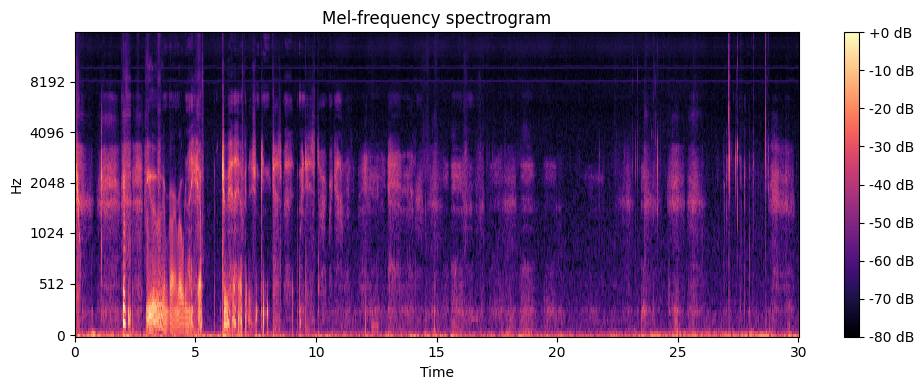

In [69]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(file_path):
    # Load the WAV file
    y, sr = librosa.load(file_path, sr=None)

    # Generate the spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=16000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    print(S_dB)

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

# Example usage
file_path =r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\bids_with_sensitive_recordings\sub-fef8f989-e8a1-429e-8406-679f47215263\ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6\audio\sub-fef8f989-e8a1-429e-8406-679f47215263_ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6_Free-speech_rec-Free-speech-1.wav'
plot_spectrogram(file_path)


[[-262.63342   -217.89717   -176.09738   ... -522.173     -516.4415
  -490.51587  ]
 [  66.41013     33.232204    27.590183  ...   63.4355      69.80025
    82.58638  ]
 [ -50.827652   -67.96759    -67.84068   ...   18.245266    22.503128
    27.26761  ]
 ...
 [  -6.902708    -5.3218637   -1.3710645 ...    4.858017     2.7824562
     4.63358  ]
 [  12.531076    10.783562     6.751033  ...    2.9466755    2.3470497
     3.141131 ]
 [   6.521343     5.449915    -5.1613073 ...    7.739834     2.5340865
     4.5723276]]


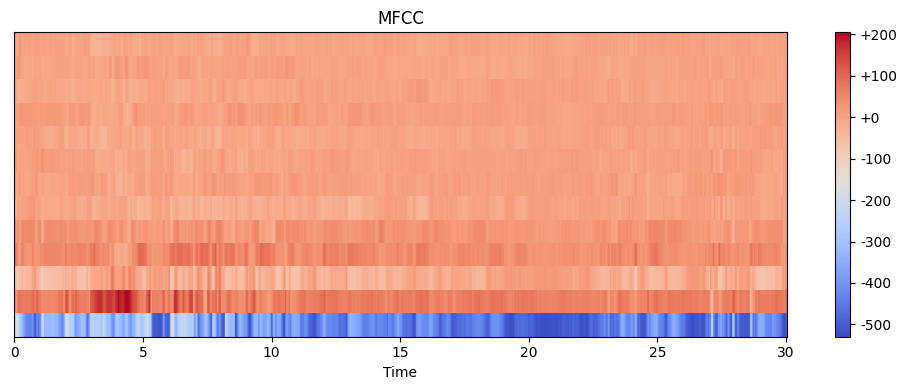

In [68]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_mfcc(file_path):
    # Load the WAV file
    y, sr = librosa.load(file_path, sr=16000)

    # Generate the MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=16000, n_mfcc=13)
    print(mfcc)

    # Plot the MFCC
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# Example usage
file_path = r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\bids_with_sensitive_recordings\sub-fef8f989-e8a1-429e-8406-679f47215263\ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6\audio\sub-fef8f989-e8a1-429e-8406-679f47215263_ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6_Free-speech_rec-Free-speech-1.wav'
plot_mfcc(file_path)


In [ ]:
import pandas as pd

In [ ]:
path = "C:/Users/shrra/Downloads/2024-06-25T13-17_export.csv"
datafram =pd.read_csv(path)

In [ ]:



def determine_new_race_5(row):
    if row['race___5'] and row['ethnicity'] == "Hispanic or Latino":
        return False
    else:
        return row['race___5']

# Apply the function to create the new column
datafram['new_race___5'] = datafram.apply(determine_new_race_5, axis=1)

# Remove rows where race___5 is false and race___8 is true
datafram = datafram[~((datafram['race___5'] == False) & (datafram['race___8'] == True))]

# race_columns = ['race___1', 'race___2', 'race___3', 'race___4', 'race___5','race___6', 'race___7','race___8','new_race___5']  
# race_counts = datafram[race_columns].sum()
# plt.figure(figsize=(10, 6))
# sns.barplot(x=race_counts.index, y=race_counts.values, palette='viridis')
# plt.xlabel('Race')
# plt.ylabel('Count')
# plt.title('Number of Counts Available for Each Race')
# plt.show()


# income_counts = datafram['household_income_usa'].value_counts()

# # Plotting the counts
# plt.figure(figsize=(10, 6))
# sns.barplot(x=income_counts.index, y=income_counts.values, palette='viridis')
# plt.xlabel('Household Income')
# plt.ylabel('Count')
# plt.title('Number of Counts Available for Each Household Income Bracket')
# plt.show()


In [ ]:
# from pydub import AudioSegment

# def get_wav_length(file_path):
#     audio = AudioSegment.from_wav(file_path)
#     duration = len(audio) / 1000.0  # Convert milliseconds to seconds
#     return duration

# # Example usage
# file_path =r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\bids_with_sensitive_recordings\sub-fef8f989-e8a1-429e-8406-679f47215263\ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6\audio\sub-fef8f989-e8a1-429e-8406-679f47215263_ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6_Free-speech_rec-Free-speech-1.wav'
# length = get_wav_length(file_path)
# print(f"Length of the WAV file: {length} seconds")


import wave

def get_wav_length(file_path):
    with wave.open(file_path, 'rb') as wav_file:
        frames = wav_file.getnframes()
        rate = wav_file.getframerate()
        duration = frames / float(rate)
        return duration

# Example usage
file_path =r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\bids_with_sensitive_recordings\sub-fef8f989-e8a1-429e-8406-679f47215263\ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6\audio\sub-fef8f989-e8a1-429e-8406-679f47215263_ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6_Free-speech_rec-Free-speech-2.wav'

length = get_wav_length(file_path)
print(f"Length of the WAV file: {length} seconds")



In [ ]:
train_df.to_csv(r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\train_rec.csv', index=False)

In [ ]:
train_df.to_csv(r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\train_rec.csv', index=False)
val_df.to_csv(r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\val_rec.csv', index=False)
test_df.to_csv(r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\test_rec.csv', index=False)

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming `df` is your dataframe
# Replace `datafram` with the actual dataframe name if different
df = datafram
selected_columns = ['record_id', 'demographics_session_id', 'new_race___5']
df = df[selected_columns]

# Add 'subject_id' column
df['subject_id'] = 'sub-' + df['record_id'] + '/ses-' + df['demographics_session_id']

# Function to check file existence
def get_valid_subject_ids(df, base_dir='C:/Users/shrra/Downloads/Bridge2AI/bridge2ai-voice-corpus-2-including-sensitive-recordings1/bids_with_sensitive_recordings/'):
    valid_ids = []
    for subject_id in df['subject_id']:
        session_dir = os.path.join(base_dir, subject_id, 'audio')
        if os.path.exists(session_dir):
            for file_name in os.listdir(session_dir):
                if file_name.endswith('Rainbow-Passage_rec-Rainbow-Passage.wav'):  # Check for .wav files
                    valid_ids.append(subject_id)
                    break
    return valid_ids

# Get valid subject IDs
valid_subject_ids = get_valid_subject_ids(df)

# Filter the dataframe to include only records with valid subject IDs
df = df[df['subject_id'].isin(valid_subject_ids)]

# Split the data into train+val and test sets (80% train+val, 20% test)
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['new_race___5'], random_state=42)

# Split the train+val set into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['new_race___5'], random_state=42)  # 0.25 * 0.8 = 0.2

# Display the number of records in each distribution
def display_distribution(df, name):
    print(f"Distribution in {name}:")
    print(df['new_race___5'].value_counts())
    print()
display_distribution(datafram, 'Original Set')
display_distribution(df, 'filtered Set')
display_distribution(train_df, 'Train Set')
display_distribution(val_df, 'Validation Set')
display_distribution(test_df, 'Test Set')


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

file_path = r'C:\Users\shrra\Downloads\Bridge2AI\bridge2ai-voice-corpus-2-including-sensitive-recordings1\bids_with_sensitive_recordings\sub-fef8f989-e8a1-429e-8406-679f47215263\ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6\audio\sub-fef8f989-e8a1-429e-8406-679f47215263_ses-9EB42BC6-6E5E-4559-8783-55980AFBA6A6_Free-speech_rec-Free-speech-2.pt'
data = torch.load(file_path)

print(data.keys())

# Assuming data['speaker_embedding'] contains speaker embeddings
speaker_embedding = data['speaker_embedding'].numpy()
print(speaker_embedding)

# Check for non-finite values and handle them
if not np.isfinite(speaker_embedding).all():
    raise ValueError("Speaker embedding data contains non-finite values")

# Plot the speaker embedding directly if it's a 1D array
plt.figure(figsize=(10, 4))
plt.plot(speaker_embedding, marker='o')
plt.title('Speaker Embedding')
plt.xlabel('Component Index')
plt.ylabel('Component Value')
plt.tight_layout()
plt.show()
